In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import pickle


In [2]:
nltk.download('stopwords')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


stemmer = SnowballStemmer("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/diskane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_text(text):
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [5]:
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
        stemSentence = stemSentence.strip('')
    return stemSentence

In [6]:
metatsv = "dataset/movie.metadata.tsv"
plot_summaries = "dataset/plot_summaries.txt"

meta = pd.read_csv(metatsv, sep = '\t', header = None)
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
genres = meta[["movie_id","movie_name","genre"]]
plots = pd.read_csv(plot_summaries, sep = '\t', header = None)
plots.columns = ["movie_id", "plot"]
plots

In [7]:
genres['movie_id'] = genres['movie_id'].astype(str)
plots['movie_id'] = plots['movie_id'].astype(str)
movies = pd.merge(plots, genres, on = 'movie_id')


    


/home/diskane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
movies

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
...,...,...,...,...
42199,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{""/m/0bj8m2"": ""Children's""}"
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
42201,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music..."
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{""/m/07s9rl0"": ""Drama""}"


In [9]:
genres_lists = []

for i in movies['genre']:
    genres_lists.append(list(json.loads(i).values()))

In [10]:
movies['genre'] = genres_lists
movies

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",Taxi Blues,"[Drama, World cinema]"
1,31186339,The nation of Panem consists of a wealthy Capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,Seventh-day Adventist Church pastor Michael Ch...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."
...,...,...,...,...
42199,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,[Children's]
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"[Silent film, Indie, Black-and-white, Period p..."
42201,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,"[Short Film, Music, Biographical film, Documen..."
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,[Drama]


In [11]:
movies['plot'] = movies['plot'].apply(clean_text)


In [12]:
movies2=movies.copy()

In [13]:
movies2['plot'] = movies['plot'].apply(stemming)
movies2

,movie_id,plot,movie_name,genre
0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"[Drama, World cinema]"
1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."
...,...,...,...,...
42199,34808485,stori reema young muslim schoolgirl malabar lo...,Oomakkuyil Padumbol,[Children's]
42200,1096473,1928 hollywood director leo andreyev look phot...,The Last Command,"[Silent film, Indie, Black-and-white, Period p..."
42201,35102018,american luthier focus randi parson transform ...,Randy Parsons: American Luthier,"[Short Film, Music, Biographical film, Documen..."
42202,8628195,abdur rehman khan middleag dri fruit seller af...,Kabuliwala,[Drama]


In [14]:
movies=movies2.copy()

In [15]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit_transform(movies['genre'])
 # transform target variable
y = multilabel_binarizer.transform(movies['genre'])

for idx, genre in enumerate(multilabel_binarizer.classes_):
    movies[genre] = y[:,idx]
    
moviesCSV="dataset/movies.csv"
movies.to_csv(moviesCSV)

,Unnamed: 0,movie_id,plot,movie_name,genre,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"['Drama', 'World cinema']",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"['Action/Adventure', 'Science Fiction', 'Actio...",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"['Musical', 'Action', 'Drama', 'Bollywood']",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,"['Screwball comedy', 'Comedy']",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"['Crime Fiction', 'Drama', 'Docudrama', 'World...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,17060199,clair mildmann park attend live small flat mot...,Expired,"['Romantic comedy', 'Indie', 'Comedy-drama', '...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,96,7481126,film centr group classmat attended chemistri c...,Classmates,"['Thriller', 'Mystery', 'Musical', 'Drama', 'C...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,97,9031450,young woman name hyuncha train look art book t...,Spring Bears Love,"['Romance Film', 'Comedy']",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,98,1520023,ninja resurrect take place tokugawa era time c...,Ninja Resurrection,"['Horror', 'World cinema', 'Animation', 'Anime...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
moviesCSV="dataset/movies.csv"
movies_new = pd.read_csv(moviesCSV,nrows=4)
movies = movies_new
movies.head(100)

,Unnamed: 0,movie_id,plot,movie_name,genre,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,0,23890098,shlykov hardwork taxi driver lyosha saxophonis...,Taxi Blues,"['Drama', 'World cinema']",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,31186339,nation panem consist wealthi capitol twelv poo...,The Hunger Games,"['Action/Adventure', 'Science Fiction', 'Actio...",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,20663735,pooval induchoodan sentenc six year prison lif...,Narasimham,"['Musical', 'Action', 'Drama', 'Bollywood']",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2231378,lemon drop kid new york citi swindler illeg to...,The Lemon Drop Kid,"['Screwball comedy', 'Comedy']",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
train, test = train_test_split(movies, random_state=42, test_size=0.30, shuffle=True)
train_text = train['plot'].values.astype('U')
test_text = test['plot'].values.astype('U')

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features = 10000)
vectorizer.fit(train_text)
vectorizer.fit(test_text)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [20]:
#print(train_text)
#print("----------------------------------------------------------------------")
#print(test_text)

In [21]:

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['movie_id', 'movie_name', 'plot', 'genre', 'Unnamed: 0'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['movie_id', 'movie_name', 'plot', 'genre', 'Unnamed: 0'], axis=1)

In [22]:
print(x_test)

  (0, 2303)	0.019617274979936598
  (0, 2302)	0.019617274979936598
  (0, 2301)	0.019617274979936598
  (0, 2300)	0.019617274979936598
  (0, 2299)	0.039234549959873195
  (0, 2295)	0.019617274979936598
  (0, 2294)	0.019617274979936598
  (0, 2293)	0.019617274979936598
  (0, 2274)	0.019617274979936598
  (0, 2273)	0.019617274979936598
  (0, 2272)	0.019617274979936598
  (0, 2271)	0.019617274979936598
  (0, 2270)	0.019617274979936598
  (0, 2269)	0.019617274979936598
  (0, 2268)	0.019617274979936598
  (0, 2267)	0.039234549959873195
  (0, 2256)	0.019617274979936598
  (0, 2255)	0.019617274979936598
  (0, 2254)	0.019617274979936598
  (0, 2253)	0.019617274979936598
  (0, 2252)	0.019617274979936598
  (0, 2251)	0.019617274979936598
  (0, 2250)	0.019617274979936598
  (0, 2249)	0.019617274979936598
  (0, 2248)	0.019617274979936598
  :	:
  (1, 58)	0.017230771798228964
  (1, 57)	0.03446154359645793
  (1, 56)	0.017230771798228964
  (1, 55)	0.017230771798228964
  (1, 54)	0.017230771798228964
  (1, 53)	0.017

In [ ]:
#Binary Relevance
br_classifier.fit(x_train, y_train)
br_predictions = br_classifier.predict(x_test)
print("Accuracy = ",accuracy_score(y_test,br_predictions.toarray()))
print("F1 score = ",F1_score(y_test,br_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_test,br_predictions))

In [ ]:
#Label Powerset
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_test)
print("Accuracy = ",accuracy_score(y_test,lp_predictions))
print("F1 score = ",f1_score(y_test,lp_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_test,lp_predictions))

In [64]:
#MLkNN
ml_classifier = MLkNN(k=10)
# to prevent errors when handling sparse matrices.
x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()
ml_classifier.fit(x_train, y_train)
# predict
ml_predictions = ml_classifier.predict(x_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,ml_predictions))

Accuracy =  0.04081632653061224


/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

t = 0.05
Accuracy =  0.0
F1 =  0.18785865297493207
Hamming loss =  0.12034550662370211
t = 0.06
Accuracy =  0.0
F1 =  0.21565617805065235
Hamming loss =  0.09147869674185463
t = 0.07
Accuracy =  0.0
F1 =  0.23648648648648646
Hamming loss =  0.07080200501253132
t = 0.08
Accuracy =  0.0
F1 =  0.2340425531914894
Hamming loss =  0.0644468313641246
t = 0.09
Accuracy =  0.0
F1 =  0.2457971014492753
Hamming loss =  0.05822592194772646
t = 0.1
Accuracy =  0.0
F1 =  0.27341079972658916
Hamming loss =  0.047574292875044756
t = 0.11
Accuracy =  0.0
F1 =  0.2865900383141763
Hamming loss =  0.041666666666666664
t = 0.12
Accuracy =  0.0
F1 =  0.2928802588996764
Hamming loss =  0.0391156462585034
t = 0.13
Accuracy =  0.0
F1 =  0.29276595744680856
Hamming loss =  0.037191192266380235
t = 0.14
Accuracy =  0.0
F1 =  0.29656419529837247
Hamming loss =  0.03481919083422843
t = 0.15
Accuracy =  0.0
F1 =  0.29378531073446323
Hamming loss =  0.03356605800214823
t = 0.16
Accuracy =  0.0
F1 =  0.28403525954946

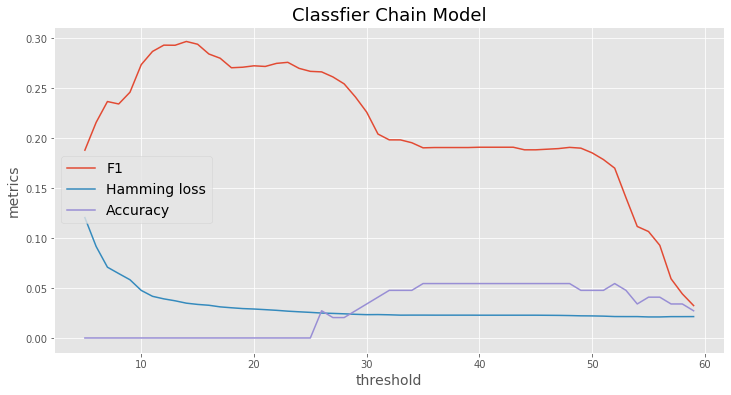

In [65]:
#for the next classifier we need to remove from y-train, y-test categories which equal 0 for all train samples
y_train = train.drop(labels = ['movie_id', 'movie_name', 'plot', 'genre', 'Unnamed: 0'], axis=1)
selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()
y_test = test.drop(labels = ['movie_id', 'movie_name', 'plot', 'genre', 'Unnamed: 0'], axis=1)
y_train = y_train.filter(selected_labels, axis=1)
y_test = y_test.filter(selected_labels, axis=1)
x_train = vectorizer.transform(train_text)
x_test = vectorizer.transform(test_text)
cc_classifier = ClassifierChain(LogisticRegression(solver='warn'))
cc_classifier.fit(x_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(x_test)
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    print("t =" ,t/100)
    print("Accuracy = ",accuracy_score(y_test,y_pred_new))
    print("F1 = ",f1_score(y_test,y_pred_new, average="micro"))
    print("Hamming loss = ",hamming_loss(y_test,y_pred_new))
    th.append(t)
    ac.append(accuracy_score(y_test,y_pred_new))
    f.append(f1_score(y_test,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_test,y_pred_new))
plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("Classfier Chain Model", fontsize = 18)
plt.show()